In [33]:
import os
import re
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

print("Ïäù=3")

Ïäù=3


In [34]:
# Ìè¨ÏßÄÏÖîÎÑê Ïù∏ÏΩîÎî© Î†àÏù¥Ïñ¥
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # Í∞ÅÎèÑ Î∞∞Ïó¥ ÏÉùÏÑ±
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # Î∞∞Ïó¥Ïùò ÏßùÏàò Ïù∏Îç±Ïä§ÏóêÎäî sin Ìï®Ïàò Ï†ÅÏö©
    sines = tf.math.sin(angle_rads[:, 0::2])
    # Î∞∞Ïó¥Ïùò ÌôÄÏàò Ïù∏Îç±Ïä§ÏóêÎäî cosine Ìï®Ïàò Ï†ÅÏö©
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sinÍ≥º cosineÏù¥ ÍµêÏ∞®ÎêòÎèÑÎ°ù Ïû¨Î∞∞Ïó¥
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

print("Ïäù=3")

Ïäù=3


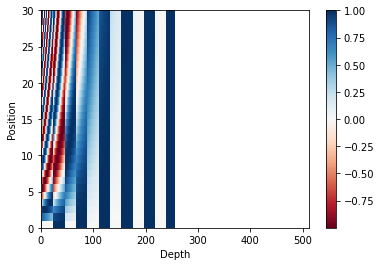

In [35]:
sample_pos_encoding = PositionalEncoding(30, 256)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

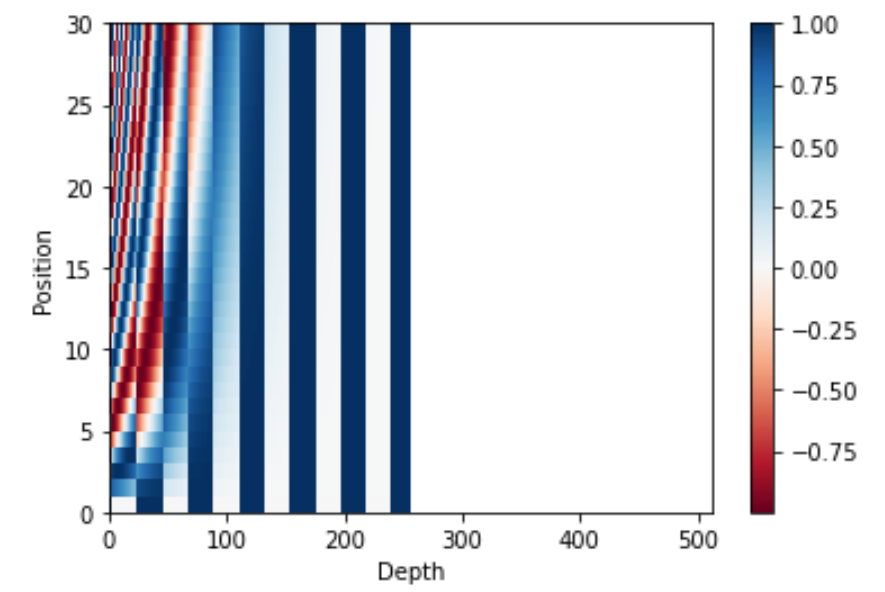

In [36]:
# Ïä§ÏºÄÏùºÎìú Îã∑ ÌîÑÎ°úÎçïÌä∏ Ïñ¥ÌÖêÏÖò Ìï®Ïàò
def scaled_dot_product_attention(query, key, value, mask):
  # Ïñ¥ÌÖêÏÖò Í∞ÄÏ§ëÏπòÎäî QÏôÄ KÏùò Îã∑ ÌîÑÎ°úÎçïÌä∏
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # Í∞ÄÏ§ëÏπòÎ•º Ï†ïÍ∑úÌôî
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # Ìå®Îî©Ïóê ÎßàÏä§ÌÅ¨ Ï∂îÍ∞Ä
  if mask is not None:
    logits += (mask * -1e9)

  # softmaxÏ†ÅÏö©
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # ÏµúÏ¢Ö Ïñ¥ÌÖêÏÖòÏùÄ Í∞ÄÏ§ëÏπòÏôÄ VÏùò Îã∑ ÌîÑÎ°úÎçïÌä∏
  output = tf.matmul(attention_weights, value)
  return output

print("Ïäù=3")

Ïäù=3


In [37]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, VÏóê Í∞ÅÍ∞Å DenseÎ•º Ï†ÅÏö©Ìï©ÎãàÎã§
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # Î≥ëÎ†¨ Ïó∞ÏÇ∞ÏùÑ ÏúÑÌïú Î®∏Î¶¨Î•º Ïó¨Îü¨ Í∞ú ÎßåÎì≠ÎãàÎã§
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # Ïä§ÏºÄÏùºÎìú Îã∑ ÌîÑÎ°úÎçïÌä∏ Ïñ¥ÌÖêÏÖò Ìï®Ïàò
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # Ïñ¥ÌÖêÏÖò Ïó∞ÏÇ∞ ÌõÑÏóê Í∞Å Í≤∞Í≥ºÎ•º Îã§Ïãú Ïó∞Í≤∞(concatenate)Ìï©ÎãàÎã§
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # ÏµúÏ¢Ö Í≤∞Í≥ºÏóêÎèÑ DenseÎ•º Ìïú Î≤à Îçî Ï†ÅÏö©Ìï©ÎãàÎã§
    outputs = self.dense(concat_attention)

    return outputs
print("Ïäù=3")

Ïäù=3


In [38]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]
print("Ïäù=3")

Ïäù=3


In [39]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)
print("Ïäù=3")

Ïäù=3


In [40]:
# Ïù∏ÏΩîÎçî ÌïòÎÇòÏùò Î†àÏù¥Ïñ¥Î•º Ìï®ÏàòÎ°ú Íµ¨ÌòÑ.
# Ïù¥ ÌïòÎÇòÏùò Î†àÏù¥Ïñ¥ ÏïàÏóêÎäî Îëê Í∞úÏùò ÏÑúÎ∏å Î†àÏù¥Ïñ¥Í∞Ä Ï°¥Ïû¨Ìï©ÎãàÎã§.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # Ìå®Îî© ÎßàÏä§ÌÅ¨ ÏÇ¨Ïö©
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # Ï≤´ Î≤àÏß∏ ÏÑúÎ∏å Î†àÏù¥Ïñ¥ : Î©ÄÌã∞ Ìó§Îìú Ïñ¥ÌÖêÏÖò ÏàòÌñâ (ÏÖÄÌîÑ Ïñ¥ÌÖêÏÖò)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # Ïñ¥ÌÖêÏÖòÏùò Í≤∞Í≥ºÎäî DropoutÍ≥º Layer NormalizationÏù¥ÎùºÎäî ÌõàÎ†®ÏùÑ ÎèïÎäî ÌÖåÌÅ¨ÎãâÏùÑ ÏàòÌñâ
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # Îëê Î≤àÏß∏ ÏÑúÎ∏å Î†àÏù¥Ïñ¥ : 2Í∞úÏùò ÏôÑÏ†ÑÏó∞Í≤∞Ï∏µ
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # ÏôÑÏ†ÑÏó∞Í≤∞Ï∏µÏùò Í≤∞Í≥ºÎäî DropoutÍ≥º LayerNormalizationÏù¥ÎùºÎäî ÌõàÎ†®ÏùÑ ÎèïÎäî ÌÖåÌÅ¨ÎãâÏùÑ ÏàòÌñâ
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("Ïäù=3")

Ïäù=3


In [41]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # Ìå®Îî© ÎßàÏä§ÌÅ¨ ÏÇ¨Ïö©
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # ÏûÑÎ≤†Îî© Î†àÏù¥Ïñ¥
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # Ìè¨ÏßÄÏÖîÎÑê Ïù∏ÏΩîÎî©
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layersÎßåÌÅº ÏåìÏïÑÏò¨Î¶∞ Ïù∏ÏΩîÎçîÏùò Ï∏µ.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("Ïäù=3")

Ïäù=3


In [42]:
# ÎîîÏΩîÎçî ÌïòÎÇòÏùò Î†àÏù¥Ïñ¥Î•º Ìï®ÏàòÎ°ú Íµ¨ÌòÑ.
# Ïù¥ ÌïòÎÇòÏùò Î†àÏù¥Ïñ¥ ÏïàÏóêÎäî ÏÑ∏ Í∞úÏùò ÏÑúÎ∏å Î†àÏù¥Ïñ¥Í∞Ä Ï°¥Ïû¨Ìï©ÎãàÎã§.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # Ï≤´ Î≤àÏß∏ ÏÑúÎ∏å Î†àÏù¥Ïñ¥ : Î©ÄÌã∞ Ìó§Îìú Ïñ¥ÌÖêÏÖò ÏàòÌñâ (ÏÖÄÌîÑ Ïñ¥ÌÖêÏÖò)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # Î©ÄÌã∞ Ìó§Îìú Ïñ¥ÌÖêÏÖòÏùò Í≤∞Í≥ºÎäî LayerNormalizationÏù¥ÎùºÎäî ÌõàÎ†®ÏùÑ ÎèïÎäî ÌÖåÌÅ¨ÎãâÏùÑ ÏàòÌñâ
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # Îëê Î≤àÏß∏ ÏÑúÎ∏å Î†àÏù¥Ïñ¥ : ÎßàÏä§ÌÅ¨Îìú Î©ÄÌã∞ Ìó§Îìú Ïñ¥ÌÖêÏÖò ÏàòÌñâ (Ïù∏ÏΩîÎçî-ÎîîÏΩîÎçî Ïñ¥ÌÖêÏÖò)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # ÎßàÏä§ÌÅ¨Îìú Î©ÄÌã∞ Ìó§Îìú Ïñ¥ÌÖêÏÖòÏùò Í≤∞Í≥ºÎäî
  # DropoutÍ≥º LayerNormalizationÏù¥ÎùºÎäî ÌõàÎ†®ÏùÑ ÎèïÎäî ÌÖåÌÅ¨ÎãâÏùÑ ÏàòÌñâ
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # ÏÑ∏ Î≤àÏß∏ ÏÑúÎ∏å Î†àÏù¥Ïñ¥ : 2Í∞úÏùò ÏôÑÏ†ÑÏó∞Í≤∞Ï∏µ
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # ÏôÑÏ†ÑÏó∞Í≤∞Ï∏µÏùò Í≤∞Í≥ºÎäî DropoutÍ≥º LayerNormalization ÏàòÌñâ
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("Ïäù=3")

Ïäù=3


In [107]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # Ìå®Îî© ÎßàÏä§ÌÅ¨
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # ÏûÑÎ≤†Îî© Î†àÏù¥Ïñ¥
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # Ìè¨ÏßÄÏÖîÎÑê Ïù∏ÏΩîÎî©
  embeddings = PositionalEncoding(MAX_LENGTH, d_model)(embeddings)

  # DropoutÏù¥ÎùºÎäî ÌõàÎ†®ÏùÑ ÎèïÎäî ÌÖåÌÅ¨ÎãâÏùÑ ÏàòÌñâ
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("Ïäù=3")

Ïäù=3


In [108]:
data_dir = os.path.expanduser('/aiffel/aiffel/transformer_chatbot/data/')
chatbot_data_path = os.path.join(data_dir, 'ChatbotData.csv')
print("Ïäù=3")

Ïäù=3


In [109]:
!wget https://github.com/songys/Chatbot_data/raw/master/ChatbotData.csv -O ~/aiffel/transformer_chatbot/data/ChatbotData.csv

--2025-04-25 08:20:42--  https://github.com/songys/Chatbot_data/raw/master/ChatbotData.csv
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv [following]
--2025-04-25 08:20:42--  https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 889842 (869K) [text/plain]
Saving to: ‚Äò/aiffel/aiffel/transformer_chatbot/data/ChatbotData.csv‚Äô

/aiffel/aiffel/tran 100%[===================>] 868.99K  --.-KB/s    in 0.03s   

2025-04-25 08:20:42 (27.0 MB/s) - ‚Äò/aiffel/aiffel/transformer_chatbot/data

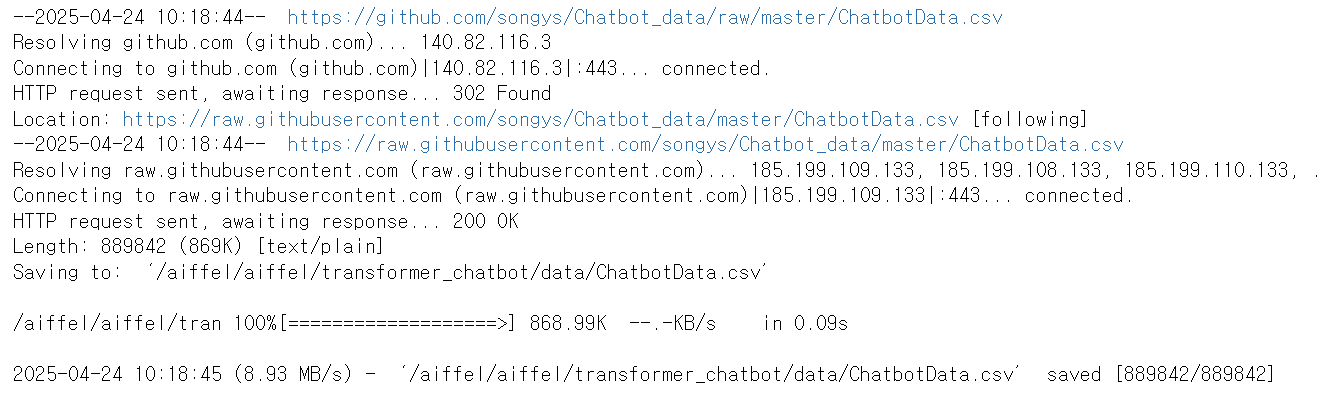
ÌååÏùº Ïó∞Í≤∞Ïù¥ Ïûò ÏûëÎèôÎêòÏßÄ ÏïäÏïÑ ÌååÏùºÏùÑ Ïû¨Îã§Ïö¥Î°úÎìúÌõÑ ÏßÑÌñâ

In [110]:
import os
print(os.path.getsize('/aiffel/aiffel/transformer_chatbot/data/ChatbotData.csv'))


889842


ÌôïÏù∏
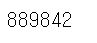

In [111]:
print(data_dir)

/aiffel/aiffel/transformer_chatbot/data/


In [112]:
# ÏÇ¨Ïö©Ìï† ÏÉòÌîåÏùò ÏµúÎåÄ Í∞úÏàò
MAX_SAMPLES = 12000
print(MAX_SAMPLES)

12000


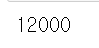

In [113]:
import re

def preprocess_sentence(sentence):
    # ÏñëÏ™Ω Í≥µÎ∞± Ï†úÍ±∞
    sentence = sentence.strip()
    
    # ÌïúÍ∏ÄÏù¥ Ìè¨Ìï®ÎêòÏñ¥ ÏûàÎäîÏßÄ ÌôïÏù∏
    if re.search(r'[\uac00-\ud7a3]', sentence):
        # ÌïúÍ∏Ä Ï≤òÎ¶¨: ÌïúÍ∏Ä, ÏòÅÏñ¥, Íµ¨ÎëêÏ†êÎßå ÎÇ®Í∏∞Í≥† ÎÇòÎ®∏ÏßÄÎäî Í≥µÎ∞±ÏúºÎ°ú ÎåÄÏ≤¥
        sentence = sentence.lower()
        # Íµ¨ÎëêÏ†ê Î∂ÑÎ¶¨
        sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
        sentence = re.sub(r'[" "]+', " ", sentence)
        # ÌïúÍ∏Ä, ÏòÅÏñ¥, Íµ¨ÎëêÏ†êÎßå ÎÇ®Í∏∞Í≥† Î™®Îëê Í≥µÎ∞±ÏúºÎ°ú
        sentence = re.sub(r"[^a-zA-ZÍ∞Ä-Ìû£?.!,]+", " ", sentence)
        sentence = sentence.strip()
        return sentence
    else:
        # ÏòÅÏñ¥ Ï≤òÎ¶¨ (Í∏∞Ï°¥Í≥º ÎèôÏùº)
        sentence = sentence.lower()
        sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
        sentence = re.sub(r'[" "]+', " ", sentence)
        sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
        sentence = sentence.strip()
        return sentence

print("Ïäù=3")
print(preprocess_sentence("ÎÇòÎäî ÌïôÍµêÏóê Í∞îÏäµÎãàÎã§!"))
# Ï∂úÎ†•: ÎÇòÎäî ÌïôÍµêÏóê Í∞îÏäµÎãàÎã§ !

print(preprocess_sentence("I am a student."))
# Ï∂úÎ†•: i am a student .


Ïäù=3
ÎÇòÎäî ÌïôÍµêÏóê Í∞îÏäµÎãàÎã§ !
i am a student .


Ï†ÑÏ≤òÎ¶¨ ÌôïÏù∏
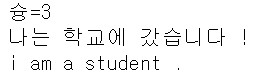

In [114]:
import pandas as pd

def load_conversations():
    chatbot_data = pd.read_csv(chatbot_data_path)
    inputs = []
    outputs = []
    
    # QÎ•º ÏûÖÎ†•, AÎ•º Ï∂úÎ†•ÏúºÎ°ú Îß§Ìïë
    for q, a in zip(chatbot_data['Q'], chatbot_data['A']):
        inputs.append(preprocess_sentence(q))
        outputs.append(preprocess_sentence(a))
        
        # ÏµúÎåÄ ÏÉòÌîå Ïàò Ï†úÌïú (ÏòµÏÖò)
        if len(inputs) >= MAX_SAMPLES:
            break
    
    return inputs, outputs

def build_contextual_pairs(questions, answers, context_size=2):
    new_inputs, new_outputs = [], []
    for i in range(context_size, len(questions)):
        context = ''
        for j in range(context_size):
            context += f"Q: {questions[i-j-1]} A: {answers[i-j-1]} "
        new_inputs.append(context + f"Q: {questions[i]}")
        new_outputs.append(answers[i])
    return new_inputs, new_outputs

print("Ïäù=3")


Ïäù=3


In [115]:
# Îç∞Ïù¥ÌÑ∞ Î°úÎìú
questions, answers = load_conversations()

# Îß•ÎùΩ Ìè¨Ìï® Ïåç ÏÉùÏÑ± (context_size=2 ÏòàÏãú)
questions, answers = build_contextual_pairs(questions, answers, context_size=2)
# Í≤∞Í≥º ÌôïÏù∏
print("ÏßàÎ¨∏ ÏòàÏãú:", questions[:3])
print("ÎãµÎ≥Ä ÏòàÏãú:", answers[:3])

ÏßàÎ¨∏ ÏòàÏãú: ['Q: ÏßÄÎßù ÌïôÍµê Îñ®Ïñ¥Ï°åÏñ¥ A: ÏúÑÎ°úÌï¥ ÎìúÎ¶ΩÎãàÎã§ . Q: Ïãú Îï° ! A: ÌïòÎ£®Í∞Ä Îòê Í∞ÄÎÑ§Ïöî . Q: Î∞ï Ïùº ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Îã§', 'Q: Î∞ï Ïùº ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Îã§ A: Ïó¨ÌñâÏùÄ Ïñ∏Ï†úÎÇò Ï¢ãÏ£† . Q: ÏßÄÎßù ÌïôÍµê Îñ®Ïñ¥Ï°åÏñ¥ A: ÏúÑÎ°úÌï¥ ÎìúÎ¶ΩÎãàÎã§ . Q: Î∞ï Ïùº Ï†ïÎèÑ ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Îã§', 'Q: Î∞ï Ïùº Ï†ïÎèÑ ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Îã§ A: Ïó¨ÌñâÏùÄ Ïñ∏Ï†úÎÇò Ï¢ãÏ£† . Q: Î∞ï Ïùº ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Îã§ A: Ïó¨ÌñâÏùÄ Ïñ∏Ï†úÎÇò Ï¢ãÏ£† . Q: ppl Ïã¨ÌïòÎÑ§']
ÎãµÎ≥Ä ÏòàÏãú: ['Ïó¨ÌñâÏùÄ Ïñ∏Ï†úÎÇò Ï¢ãÏ£† .', 'Ïó¨ÌñâÏùÄ Ïñ∏Ï†úÎÇò Ï¢ãÏ£† .', 'ÎààÏÇ¥Ïù¥ Ï∞åÌë∏Î†§ÏßÄÏ£† .']


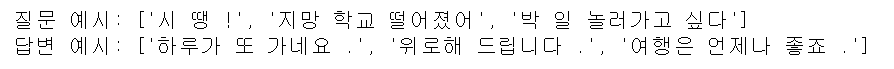

In [116]:
print('Ï†ÑÏ≤òÎ¶¨ ÌõÑÏùò 22Î≤àÏß∏ ÏßàÎ¨∏ ÏÉòÌîå: {}'.format(questions[22]))
print('Ï†ÑÏ≤òÎ¶¨ ÌõÑÏùò 22Î≤àÏß∏ ÎãµÎ≥Ä ÏÉòÌîå: {}'.format(answers[22]))

Ï†ÑÏ≤òÎ¶¨ ÌõÑÏùò 22Î≤àÏß∏ ÏßàÎ¨∏ ÏÉòÌîå: Q: Í∞ÄÏ°± Ïó¨Ìñâ Í∞ÄÍ∏∞Î°ú ÌñàÏñ¥ A: Ïò® Í∞ÄÏ°±Ïù¥ Î™®Îëê ÎßàÏùåÏóê ÎìúÎäî Í≥≥ÏúºÎ°ú Í∞ÄÎ≥¥ÏÑ∏Ïöî . Q: Í∞ÄÏû• ÌôïÏã§Ìïú Í±¥ Î≠òÍπå ? A: Í∞ÄÏû• ÌôïÏã§Ìïú ÏãúÍ∞ÑÏùÄ Ïò§ÎäòÏù¥ÏóêÏöî . Ïñ¥Ï†úÏôÄ ÎÇ¥ÏùºÏùÑ ÎÜìÍ≥† Í≥†ÎØºÌïòÎäêÎùº ÏãúÍ∞ÑÏùÑ ÎÇ≠ÎπÑÌïòÏßÄ ÎßàÏÑ∏Ïöî . Q: Í∞ÄÏ°± Ïó¨Ìñâ Í≥†Í≥†
Ï†ÑÏ≤òÎ¶¨ ÌõÑÏùò 22Î≤àÏß∏ ÎãµÎ≥Ä ÏÉòÌîå: Ïò® Í∞ÄÏ°±Ïù¥ Î™®Îëê ÎßàÏùåÏóê ÎìúÎäî Í≥≥ÏúºÎ°ú Í∞ÄÎ≥¥ÏÑ∏Ïöî .


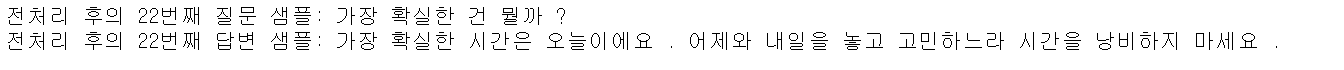

In [117]:
import tensorflow_datasets as tfds
print("ÏÇ¥Ïßù Ïò§Îûò Í±∏Î¶¥ Ïàò ÏûàÏñ¥Ïöî. Ïä§Ìä∏Î†àÏπ≠ Ìïú Î≤à Ìï¥Î≥ºÍπåÏöî? üëê")

# ÏßàÎ¨∏Í≥º ÎãµÎ≥Ä Îç∞Ïù¥ÌÑ∞ÏÖãÏóê ÎåÄÌï¥ÏÑú Vocabulary ÏÉùÏÑ±
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)
print("Ïäù=3 ")

ÏÇ¥Ïßù Ïò§Îûò Í±∏Î¶¥ Ïàò ÏûàÏñ¥Ïöî. Ïä§Ìä∏Î†àÏπ≠ Ìïú Î≤à Ìï¥Î≥ºÍπåÏöî? üëê
Ïäù=3 


In [118]:
# ÏãúÏûë ÌÜ†ÌÅ∞Í≥º Ï¢ÖÎ£å ÌÜ†ÌÅ∞Ïóê Í≥†Ïú†Ìïú Ï†ïÏàòÎ•º Î∂ÄÏó¨Ìï©ÎãàÎã§.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
print("Ïäù=3")

Ïäù=3


In [119]:
print('START_TOKENÏùò Î≤àÌò∏ :' ,[tokenizer.vocab_size])
print('END_TOKENÏùò Î≤àÌò∏ :' ,[tokenizer.vocab_size + 1])

START_TOKENÏùò Î≤àÌò∏ : [8305]
END_TOKENÏùò Î≤àÌò∏ : [8306]


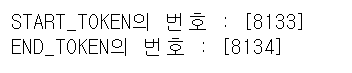

In [120]:
# ÏãúÏûë ÌÜ†ÌÅ∞Í≥º Ï¢ÖÎ£å ÌÜ†ÌÅ∞ÏùÑ Í≥†Î†§ÌïòÏó¨ +2Î•º ÌïòÏó¨ Îã®Ïñ¥Ïû•Ïùò ÌÅ¨Í∏∞Î•º ÏÇ∞Ï†ïÌï©ÎãàÎã§.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8307


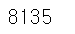

In [121]:
# ÏûÑÏùòÏùò 22Î≤àÏß∏ ÏÉòÌîåÏóê ÎåÄÌï¥ÏÑú Ï†ïÏàò Ïù∏ÏΩîÎî© ÏûëÏóÖÏùÑ ÏàòÌñâ.
# Í∞Å ÌÜ†ÌÅ∞ÏùÑ Í≥†Ïú†Ìïú Ï†ïÏàòÎ°ú Î≥ÄÌôò
print('Ï†ïÏàò Ïù∏ÏΩîÎî© ÌõÑÏùò 21Î≤àÏß∏ ÏßàÎ¨∏ ÏÉòÌîå: {}'.format(tokenizer.encode(questions[21])))
print('Ï†ïÏàò Ïù∏ÏΩîÎî© ÌõÑÏùò 21Î≤àÏß∏ ÎãµÎ≥Ä ÏÉòÌîå: {}'.format(tokenizer.encode(answers[21])))

Ï†ïÏàò Ïù∏ÏΩîÎî© ÌõÑÏùò 21Î≤àÏß∏ ÏßàÎ¨∏ ÏÉòÌîå: [8130, 1, 371, 805, 39, 582, 4, 8114, 1, 371, 805, 894, 6697, 2, 5206, 7745, 1104, 7935, 347, 5691, 42, 2, 8130, 1, 5852, 603, 2518, 4236, 8081, 8114, 1, 2366, 7654, 10, 6435, 103, 2, 8130, 1, 5844, 420, 8042, 391]
Ï†ïÏàò Ïù∏ÏΩîÎî© ÌõÑÏùò 21Î≤àÏß∏ ÎãµÎ≥Ä ÏÉòÌîå: [1084, 3173, 584, 252, 857, 610, 282, 3]


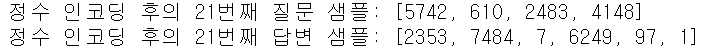

In [122]:
# ÏÉòÌîåÏùò ÏµúÎåÄ ÌóàÏö© Í∏∏Ïù¥ ÎòêÎäî Ìå®Îî© ÌõÑÏùò ÏµúÏ¢Ö Í∏∏Ïù¥
MAX_LENGTH = 40
print(MAX_LENGTH)

40


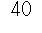

In [123]:
# Ï†ïÏàò Ïù∏ÏΩîÎî©, ÏµúÎåÄ Í∏∏Ïù¥Î•º Ï¥àÍ≥ºÌïòÎäî ÏÉòÌîå Ï†úÍ±∞, Ìå®Îî©
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # Ï†ïÏàò Ïù∏ÏΩîÎî© Í≥ºÏ†ïÏóêÏÑú ÏãúÏûë ÌÜ†ÌÅ∞Í≥º Ï¢ÖÎ£å ÌÜ†ÌÅ∞ÏùÑ Ï∂îÍ∞Ä
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # ÏµúÎåÄ Í∏∏Ïù¥ 40 Ïù¥ÌïòÏù∏ Í≤ΩÏö∞ÏóêÎßå Îç∞Ïù¥ÌÑ∞ÏÖãÏúºÎ°ú ÌóàÏö©
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # ÏµúÎåÄ Í∏∏Ïù¥ 40ÏúºÎ°ú Î™®Îì† Îç∞Ïù¥ÌÑ∞ÏÖãÏùÑ Ìå®Îî©
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs
print("Ïäù=3")

Ïäù=3


In [124]:
questions, answers = tokenize_and_filter(questions, answers)
print('Îã®Ïñ¥Ïû•Ïùò ÌÅ¨Í∏∞ :',(VOCAB_SIZE))
print('ÌïÑÌÑ∞ÎßÅ ÌõÑÏùò ÏßàÎ¨∏ ÏÉòÌîå Í∞úÏàò: {}'.format(len(questions)))
print('ÌïÑÌÑ∞ÎßÅ ÌõÑÏùò ÎãµÎ≥Ä ÏÉòÌîå Í∞úÏàò: {}'.format(len(answers)))

Îã®Ïñ¥Ïû•Ïùò ÌÅ¨Í∏∞ : 8307
ÌïÑÌÑ∞ÎßÅ ÌõÑÏùò ÏßàÎ¨∏ ÏÉòÌîå Í∞úÏàò: 6721
ÌïÑÌÑ∞ÎßÅ ÌõÑÏùò ÎãµÎ≥Ä ÏÉòÌîå Í∞úÏàò: 6721


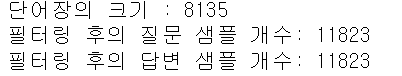

In [125]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# ÎîîÏΩîÎçîÎäî Ïù¥Ï†ÑÏùò targetÏùÑ Îã§ÏùåÏùò inputÏúºÎ°ú ÏÇ¨Ïö©Ìï©ÎãàÎã§.
# Ïù¥Ïóê Îî∞Îùº outputsÏóêÏÑúÎäî START_TOKENÏùÑ Ï†úÍ±∞ÌïòÍ≤†ÏäµÎãàÎã§.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
print("Ïäù=3")

Ïäù=3


In [126]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # Ïù∏ÏΩîÎçîÏóêÏÑú Ìå®Îî©ÏùÑ ÏúÑÌïú ÎßàÏä§ÌÅ¨
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # ÎîîÏΩîÎçîÏóêÏÑú ÎØ∏ÎûòÏùò ÌÜ†ÌÅ∞ÏùÑ ÎßàÏä§ÌÅ¨ ÌïòÍ∏∞ ÏúÑÌï¥ÏÑú ÏÇ¨Ïö©Ìï©ÎãàÎã§.
  # ÎÇ¥Î∂ÄÏ†ÅÏúºÎ°ú Ìå®Îî© ÎßàÏä§ÌÅ¨ÎèÑ Ìè¨Ìï®ÎêòÏñ¥Ï†∏ ÏûàÏäµÎãàÎã§.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # Îëê Î≤àÏß∏ Ïñ¥ÌÖêÏÖò Î∏îÎ°ùÏóêÏÑú Ïù∏ÏΩîÎçîÏùò Î≤°ÌÑ∞Îì§ÏùÑ ÎßàÏä§ÌÇπ
  # ÎîîÏΩîÎçîÏóêÏÑú Ìå®Îî©ÏùÑ ÏúÑÌïú ÎßàÏä§ÌÅ¨
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # Ïù∏ÏΩîÎçî
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # ÎîîÏΩîÎçî
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # ÏôÑÏ†ÑÏó∞Í≤∞Ï∏µ
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)
print("Ïäù=3")

Ïäù=3


In [127]:
'''
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'pos_encoding': self.pos_encoding,
        })
        return config

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            np.arange(position)[:, np.newaxis],
            np.arange(d_model)[np.newaxis, :],
            d_model)
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        pos_encoding = angle_rads[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)

    def get_angles(self, pos, i, d_model):
        angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
        return pos * angle_rates

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]
print("Ïäù=3")'''

'\nclass PositionalEncoding(tf.keras.layers.Layer):\n    def __init__(self, position, d_model):\n        super(PositionalEncoding, self).__init__()\n        self.pos_encoding = self.positional_encoding(position, d_model)\n\n    def get_config(self):\n        config = super().get_config().copy()\n        config.update({\n            \'pos_encoding\': self.pos_encoding,\n        })\n        return config\n\n    def positional_encoding(self, position, d_model):\n        angle_rads = self.get_angles(\n            np.arange(position)[:, np.newaxis],\n            np.arange(d_model)[np.newaxis, :],\n            d_model)\n        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])\n        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])\n        pos_encoding = angle_rads[np.newaxis, ...]\n        return tf.cast(pos_encoding, dtype=tf.float32)\n\n    def get_angles(self, pos, i, d_model):\n        angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))\n        return pos * angle_

In [128]:
import numpy as np
tf.keras.backend.clear_session()

# ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞
NUM_LAYERS = 2 # Ïù∏ÏΩîÎçîÏôÄ ÎîîÏΩîÎçîÏùò Ï∏µÏùò Í∞úÏàò
D_MODEL = 256 # Ïù∏ÏΩîÎçîÏôÄ ÎîîÏΩîÎçî ÎÇ¥Î∂ÄÏùò ÏûÖ, Ï∂úÎ†•Ïùò Í≥†Ï†ï Ï∞®Ïõê
NUM_HEADS = 8 # Î©ÄÌã∞ Ìó§Îìú Ïñ¥ÌÖêÏÖòÏóêÏÑúÏùò Ìó§Îìú Ïàò 
UNITS = 512 # ÌîºÎìú Ìè¨ÏõåÎìú Ïã†Í≤ΩÎßùÏùò ÏùÄÎãâÏ∏µÏùò ÌÅ¨Í∏∞
DROPOUT = 0.1 # ÎìúÎ°≠ÏïÑÏõÉÏùò ÎπÑÏú®

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3180800     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

Î™®Îç∏
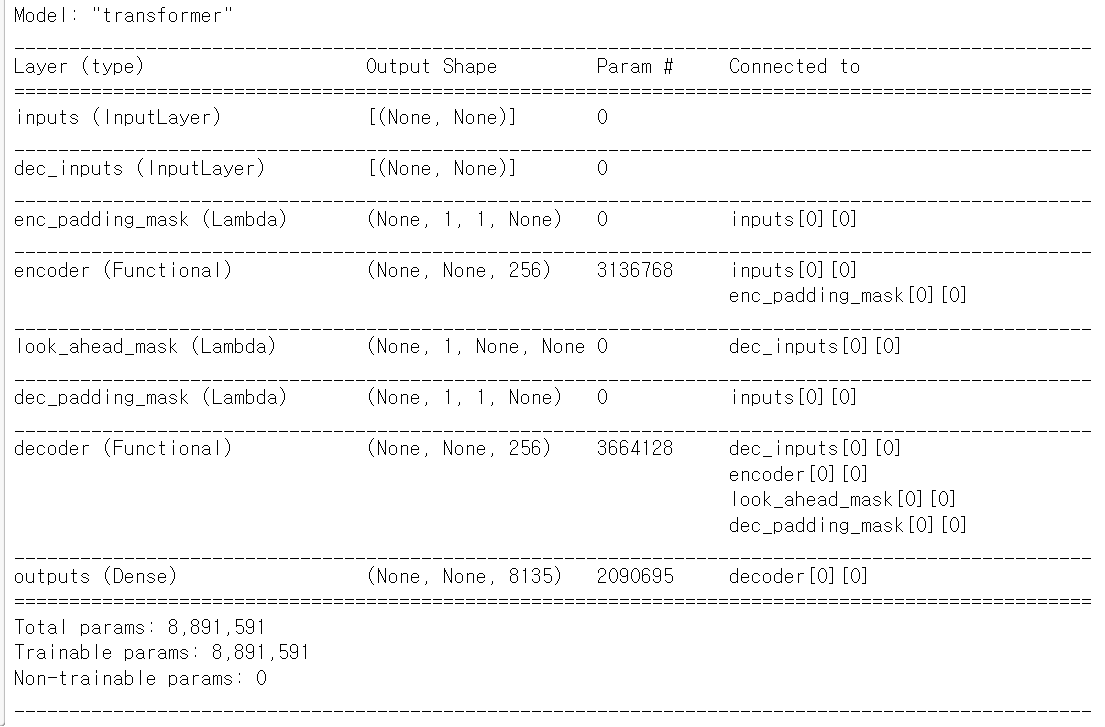

In [129]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)
print("Ïäù=3")

Ïäù=3


In [130]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=8000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
print("Ïäù=3")

Ïäù=3


Text(0.5, 0, 'Train Step')

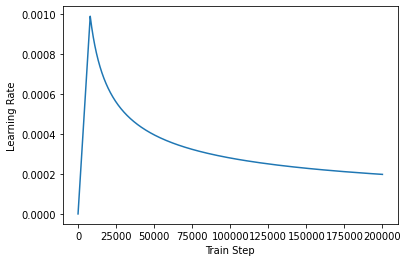

In [131]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

ÏãúÍ∞ÅÌôîÏûêÎ£å
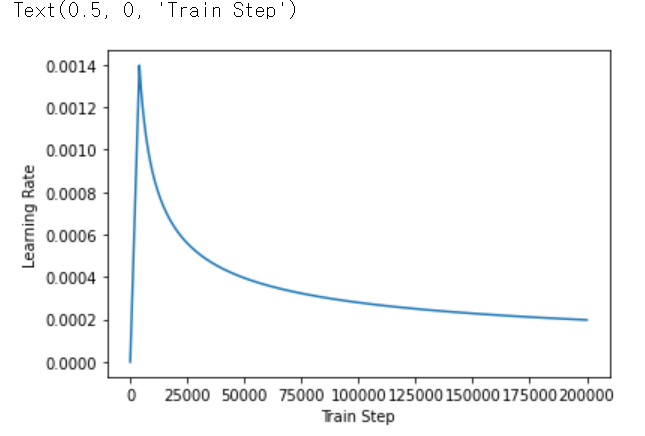

In [132]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
print("Ïäù=3")

Ïäù=3


In [133]:
EPOCHS = 20
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
106/106 [==============================] - 12s 55ms/step - loss: 1.4497 - accuracy: 0.0099
Epoch 2/20
106/106 [==============================] - 6s 55ms/step - loss: 1.3447 - accuracy: 0.0321
Epoch 3/20
106/106 [==============================] - 6s 56ms/step - loss: 1.2649 - accuracy: 0.0477
Epoch 4/20
106/106 [==============================] - 6s 56ms/step - loss: 1.1617 - accuracy: 0.0490
Epoch 5/20
106/106 [==============================] - 6s 56ms/step - loss: 1.0675 - accuracy: 0.0493
Epoch 6/20
106/106 [==============================] - 6s 56ms/step - loss: 0.9900 - accuracy: 0.0496
Epoch 7/20
106/106 [==============================] - 6s 56ms/step - loss: 0.9322 - accuracy: 0.0497
Epoch 8/20
106/106 [==============================] - 6s 56ms/step - loss: 0.8903 - accuracy: 0.0506
Epoch 9/20
106/106 [==============================] - 6s 57ms/step - loss: 0.8612 - accuracy: 0.0518
Epoch 10/20
106/106 [==============================] - 6s 57ms/step - loss: 0.8357 - accur

ÌõàÎ†®
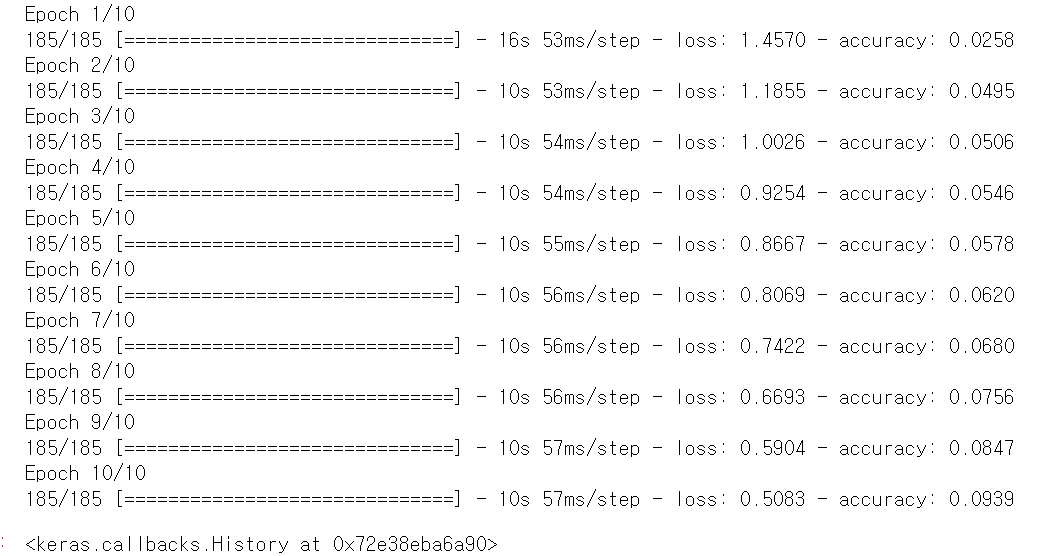
Í≤∞Í≥ºÍ∞íÏùÄ Í∑∏Î†áÍ≤å Ï¢ãÏïÑÎ≥¥Ïù¥ÏßÄÎäî ÏïäÎäîÎã§

In [134]:
'''
def decoder_inference(sentence,top_k=5):
    sentence = preprocess_sentence(sentence)

    # ÏûÖÎ†•Îêú Î¨∏Ïû•ÏùÑ Ï†ïÏàò Ïù∏ÏΩîÎî© ÌõÑ, ÏãúÏûë ÌÜ†ÌÅ∞Í≥º Ï¢ÖÎ£å ÌÜ†ÌÅ∞ÏùÑ ÏïûÎí§Î°ú Ï∂îÍ∞Ä.
    # ex) Where have you been? ‚Üí [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    # ÎîîÏΩîÎçîÏùò ÌòÑÏû¨ÍπåÏßÄÏùò ÏòàÏ∏°Ìïú Ï∂úÎ†• ÏãúÌÄÄÏä§Í∞Ä ÏßÄÏÜçÏ†ÅÏúºÎ°ú Ï†ÄÏû•ÎêòÎäî Î≥ÄÏàò.
    # Ï≤òÏùåÏóêÎäî ÏòàÏ∏°Ìïú ÎÇ¥Ïö©Ïù¥ ÏóÜÏùåÏúºÎ°ú ÏãúÏûë ÌÜ†ÌÅ∞Îßå Î≥ÑÎèÑ Ï†ÄÏû•. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # ÎîîÏΩîÎçîÏùò Ïù∏ÌçºÎü∞Ïä§ Îã®Í≥Ñ
    for i in range(MAX_LENGTH):
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1, :]
        predicted_id = tf.random.categorical(predictions, num_samples=top_k)
        predicted_id = predicted_id[0, 0].numpy()
        if predicted_id == END_TOKEN[0]:
            break
        output_sequence = tf.concat([output_sequence, [[predicted_id]]], axis=-1)
    return tf.squeeze(output_sequence, axis=0)'''
def decoder_inference(sentence, top_k=5, temperature=0.7):
    sentence = preprocess_sentence(sentence)
    sentence = tf.expand_dims(START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    for i in range(MAX_LENGTH):
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1, :]
        # temperature Ï†ÅÏö©
        predictions = predictions / temperature
        # Top-k ÏÉòÌîåÎßÅ Ï†ÅÏö©
        predicted_id = tf.random.categorical(predictions, num_samples=top_k)
        predicted_id = predicted_id[0, 0].numpy()
        if predicted_id == END_TOKEN[0]:
            break
        output_sequence = tf.concat([output_sequence, [[predicted_id]]], axis=-1)
    return tf.squeeze(output_sequence, axis=0)

print("Ïäù=3")

Ïäù=3


In [135]:
def sentence_generation(sentence):
  # ÏûÖÎ†• Î¨∏Ïû•Ïóê ÎåÄÌï¥ÏÑú ÎîîÏΩîÎçîÎ•º ÎèôÏûë ÏãúÏºú ÏòàÏ∏°Îêú Ï†ïÏàò ÏãúÌÄÄÏä§Î•º Î¶¨ÌÑ¥Î∞õÏäµÎãàÎã§.
  prediction = decoder_inference(sentence)

  # Ï†ïÏàò ÏãúÌÄÄÏä§Î•º Îã§Ïãú ÌÖçÏä§Ìä∏ ÏãúÌÄÄÏä§Î°ú Î≥ÄÌôòÌï©ÎãàÎã§.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('ÏûÖÎ†• : {}'.format(sentence))
  print('Ï∂úÎ†• : {}'.format(predicted_sentence))

  return predicted_sentence
print("Ïäù=3")

Ïäù=3


In [136]:
print(sentence_generation('ÎÇò Ïò§Îäò Í∏∞Î∂ÑÏù¥ ÏïàÏ¢ãÏïÑ'))
# Ï∂úÎ†• Ïòà: Í∏∞Î∂ÑÏù¥ Ïïà Ï¢ãÏùÑ Îïê Ï°∞Ïö©Ìïú ÏùåÏïÖÏùÑ Îì§Ïñ¥Î≥¥ÏÑ∏Ïöî .


ÏûÖÎ†• : ÎÇò Ïò§Îäò Í∏∞Î∂ÑÏù¥ ÏïàÏ¢ãÏïÑ
Ï∂úÎ†• : ÌõÑÌè≠ÌíçÏùÄ Í≤ÉÏùÑ Í±¥ Ïùò ÏãúÍ∞ÑÏù¥ Ïâ¨Í≥† Î≥¥Îã§ Ï¢ãÏ£† .
ÌõÑÌè≠ÌíçÏùÄ Í≤ÉÏùÑ Í±¥ Ïùò ÏãúÍ∞ÑÏù¥ Ïâ¨Í≥† Î≥¥Îã§ Ï¢ãÏ£† .


In [137]:
sentence_generation('ÎÇò Ïò§Îäò Í∏∞Î∂ÑÏù¥ ÏïàÏ¢ãÏïÑ')
sentence_generation('ÏãúÌóòÏùÑ ÏûòÎ¥êÏÑú ÎÑàÎ¨¥ Ï¢ãÏïÑ')

ÏûÖÎ†• : ÎÇò Ïò§Îäò Í∏∞Î∂ÑÏù¥ ÏïàÏ¢ãÏïÑ
Ï∂úÎ†• : Ï†úÍ∞Ä ÏïÑÎ¨¥Í≤ÉÎèÑ Î©¥ Î©¥ ÏÑ†Î¨ºÏùÄ ÎÑàÎ¨¥ ÎßéÏù¥ Í∑Ä ÎßûÎäî Í±∞ÏòàÏöî .
ÏûÖÎ†• : ÏãúÌóòÏùÑ ÏûòÎ¥êÏÑú ÎÑàÎ¨¥ Ï¢ãÏïÑ
Ï∂úÎ†• : Ï¢ãÏùÄ ÏßÄÎÇ¥Í≥† ÏïÑÎãàÏóêÏöî .


'Ï¢ãÏùÄ ÏßÄÎÇ¥Í≥† ÏïÑÎãàÏóêÏöî .'

Ïù¥ÏÉÅÌïú ÎßêÏùÑ ÌïúÎã§
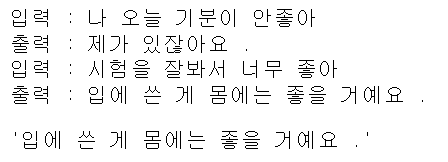


In [138]:
sentence_generation('Í∏∞Î∂Ñ ÏïäÏ¢ãÏùÑÎñÑÎäî Ïñ¥ÎñªÍ≤å Ìï¥Ïïº Ìï†Íπå?')

ÏûÖÎ†• : Í∏∞Î∂Ñ ÏïäÏ¢ãÏùÑÎñÑÎäî Ïñ¥ÎñªÍ≤å Ìï¥Ïïº Ìï†Íπå?
Ï∂úÎ†• : Îê† Í±∞ÏòàÏöî .


'Îê† Í±∞ÏòàÏöî .'

In [139]:
sentence_generation('Ïò§Îäò ÎÇ†Ïî® Ï¢ãÎã§')

ÏûÖÎ†• : Ïò§Îäò ÎÇ†Ïî® Ï¢ãÎã§
Ï∂úÎ†• : Ïûò Ìï¥Í≤∞ÎêòÍ∏∏ Î∞îÎûÑÍ≤åÏöî .


'Ïûò Ìï¥Í≤∞ÎêòÍ∏∏ Î∞îÎûÑÍ≤åÏöî .'

In [140]:
sentence_generation('Í∑∏Îßå')

ÏûÖÎ†• : Í∑∏Îßå
Ï∂úÎ†• : ÎßéÏù¥ ÏßÄÎÇ¥Í≥† Î¥êÏöî .


'ÎßéÏù¥ ÏßÄÎÇ¥Í≥† Î¥êÏöî .'

In [141]:
sentence_generation('Î©àÏ∂∞')

ÏûÖÎ†• : Î©àÏ∂∞
Ï∂úÎ†• : ÎßàÏùåÏù¥ ÎßàÏùåÏóê Ï¢ãÏ£† .


'ÎßàÏùåÏù¥ ÎßàÏùåÏóê Ï¢ãÏ£† .'

In [142]:
sentence_generation('Ïò§Îäò ÌûòÎì§Ïñ¥')

ÏûÖÎ†• : Ïò§Îäò ÌûòÎì§Ïñ¥
Ï∂úÎ†• : Îçî Ï¢ãÏùÄ ÏÉùÍ∞ÅÎßå ÌïòÏÑ∏Ïöî .


'Îçî Ï¢ãÏùÄ ÏÉùÍ∞ÅÎßå ÌïòÏÑ∏Ïöî .'

In [150]:
sentence_generation('ÏßúÏ¶ùÎÇò')

ÏûÖÎ†• : ÏßúÏ¶ùÎÇò
Ï∂úÎ†• : ÎßéÏù¥ Îã§Ïù¥Ïñ¥Ìä∏ ÌûòÎì§Í≤†ÏßÄÎßå Ïïà Ìï† Í±∞ÏòàÏöî !


'ÎßéÏù¥ Îã§Ïù¥Ïñ¥Ìä∏ ÌûòÎì§Í≤†ÏßÄÎßå Ïïà Ìï† Í±∞ÏòàÏöî !'

lmsÏÉÅÏóêÏÑú ÏßÑÌñâÌïú ÏΩîÎìúÎ•º Í±∞Ïùò ÎèôÏùºÌïòÍ≤å ÏÇ¨Ïö©ÌñàÎäîÎç∞ Í≤∞Í≥ºÍ∞íÏù¥ Ï¢ãÏßÄ ÏïäÏïÑ Ï°∞Í∏à Îçî Ï¢ãÍ≤å ÎÇòÏò¨Ïàò ÏûàÍ≤å ÏàòÏ†ïÏùÑ Ìï¥ÏïºÌï† Í≤É Í∞ôÎã§.

Î≥ÄÍ≤Ω ÌïôÏäµÏùÑ 20Î≤àÏúºÎ°ú ÏàòÏ†ï,Îß•ÎùΩÌååÏïÖ Ìï®ÏàòÎ•º Ï∂îÍ∞Ä,ÎîîÏΩîÎçî Î∂ÄÎ∂ÑÏùÑ top-kÎ∞©Ïãù ÏÇ¨Ïö©,ÏûÑÎ≤†Îî©ÏùÑ max_lengthÎ°ú Î≥ÄÍ≤Ω

Í∞êÏÑ±Ï†ÅÏù∏ ÎßêÏùÑ ÌñàÏùÑ ÎñÑ Îçî Ï†ïÏÉÅÏ†ÅÏù∏ ÎãµÎ≥ÄÏù¥ ÎèåÏïÑÏò§Îäî Í≤É Í∞ôÎã§.Ïù¥Ïô∏Ïùò ÎßêÏóêÎäîÎ≥ÄÍ≤ΩÏùÑ ÌñàÏùÑÎïå Ï°∞Í∏àÏùÄ Îã¨ÎùºÏßÑ Í≤É Í∞ôÏùÄÎç∞ ÎßêÏùÄ Ïó≠Ïãú Ïñ¥Î†§Ïö¥Í≤É Í∞ôÎã§. ÏóÑÏ≤≠ÎÇú Î≥ÄÌôî ÏÇ¨ÎûåÏ≤òÎüº ÏûêÏó∞Ïä§Îü¨ÏõÄÏùÄ Ïûò Î™ªÎäêÍºáÎã§Ìä∏ÎûúÏä§Ìè¨Î®∏ Î™®Îç∏ÏùÄ Ï¢Ä Ïñ¥Î†µÎã§Îäî Í±∏ Îã§ÏãúÍ∏à ÏÉùÍ∞ÅÌïòÍ≤å ÎêòÍ≥† Ï±óÎ¥áÏùÑ ÎßåÎìúÎ†§Î©¥ Ïö∞ÏÑ† Ï∂©Î∂ÑÌïú Îç∞Ïù¥ÌÑ∞Î•º ÌôïÎ≥¥Î•º Ìï¥ÏïºÍ≤†Îã§Îäî Í≤ÉÏùÑ ÎäêÎÅºÍ≤å ÎêúÍ≤ÉÍ∞ôÎã§.